In [103]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

from itertools import product
import pandas as pd
import numpy as np
from numpy.linalg import lstsq
from sklearn.model_selection import KFold
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from matplotlib import colors
plt.style.use('homework')

# Fitting

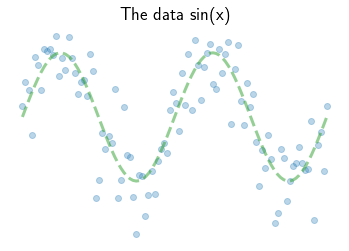

In [345]:
rng = np.random.default_rng(seed=1)
N = 100
freq = 1
periods = 2
coef = freq * 2 *np.pi
x = np.linspace(-periods/2, periods/2, N)
sine = np.sin(coef * x)
nonlin = np.sin(coef * x) + rng.normal(scale=.5, size=N)

def plot_sine(x=x, data=nonlin, actual=sine, title=f"The data sin(x)", fig=None, ax=None, labels=False):
    if ax is None:
        fig, ax = plt.subplots()
    if labels:
        sl = "sin(x)"
        dl = "Data"
    else:
        sl=None
        dl=None

    ax.plot(x, nonlin, 'o', alpha=0.3, label=dl)
    ax.plot(x, sine, lw=3, color='C2', ls='dashed', alpha=0.5, label=sl)
    ax.set_title(title)
    ax.axis('off');
    return fig, ax

fig, ax = plot_sine(x, nonlin, sine)
# fig.savefig("../img/fitting/sine_data.png")

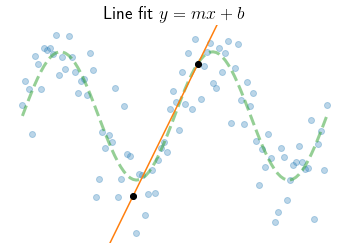

In [11]:
fig, ax = plot_sine(x, nonlin, sine, r'Line fit $y = mx + b$')

# x = np.linspace(0, 2*np.pi, N)

def gen_line(idx = None):
    if idx is None:
        idx = rng.choice(np.arange(N), 2)
    x1, x2 = x[idx]
    y1, y2 = nonlin[idx]
    m = (y2-y1) / (x2-x1)
    b = y1 - x1*m
    line = m * x + b
    return line, [x1, x2], [y1, y2]


line, xd, yd = gen_line()
ylims = ax.get_ylim()
arline, = ax.plot(x, line)
arpts, = ax.plot(xd, yd, 'ko')
ax.set_ylim(ylims)


def animate(i):
    line, xd, yd = gen_line()
    arline.set_data(x, line)
    arpts.set_data(xd, yd)

    return arline, arpts


ani = animation.FuncAnimation(
    fig, animate, interval=1000, blit=True, save_count=20, )
ani.save("line_fit.gif", dpi=200)

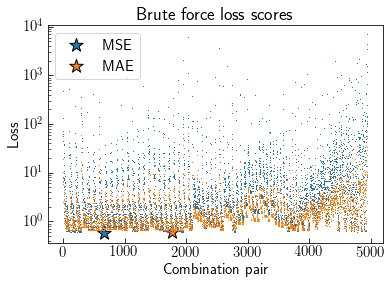

In [12]:
from itertools import combinations

mse_list = []
mae_list = []
mae_min = np.inf
mae_argmin = None
mse_min = np.inf
mse_argmin = None

for i in combinations(np.arange(N), 2):
    line, _, _ = gen_line(np.array(i))
    mse = np.square(line - nonlin).mean()
    if mse < mse_min:
        mse_min = mse
        mse_argmin = np.array(i)
    mse_list.append(mse)
    mae = np.abs(line - nonlin).mean()
    if mae < mae_min:
        mae_min = mae
        mae_argmin = np.array(i)
    mae_list.append(mae)

mse_min = np.array(mse_list).argmin()
mae_min = np.array(mae_list).argmin()
plt.plot(mse_list, ',')
plt.plot(mae_list, ',')
plt.scatter(mse_min, mse_list[mse_min], s=200, marker='*', edgecolors='k', label="MSE")
plt.scatter(mae_min, mae_list[mae_min], s=200, marker='*', edgecolors='k', label="MAE")
plt.legend()
plt.yscale('log')
plt.ylabel("Loss")
plt.xlabel("Combination pair")
plt.title("Brute force loss scores")
plt.savefig("../img/fitting/pair_loss.png")

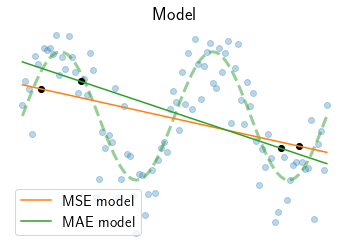

In [13]:
fig, ax = plot_sine(x, nonlin, sine, "Model")
mse_line, xd, yd = gen_line(mse_argmin)
ax.plot(xd, yd, 'ko')
ax.plot(x, mse_line, label="MSE model")
mae_line, xd, yd = gen_line(mae_argmin)
ax.plot(xd, yd, 'ko')
ax.plot(x, mae_line, label="MAE model")
ax.legend()
fig.savefig("../img/fitting/pair_model_fit.png")

Text(0.5, 1.0, 'Residual plot')

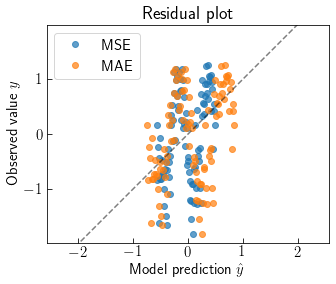

In [16]:
plt.plot(mse_line, nonlin, 'o', alpha=0.7, label="MSE")
plt.plot(mae_line, nonlin, 'o', alpha=0.7, label="MAE")
plt.axis('square')
xlim, ylim = plt.xlim(), plt.ylim()
xmax = max([abs(x) for x in xlim])
ymax = max([abs(x) for x in ylim])
normline = np.linspace(-xmax, xmax)
plt.plot(normline, normline, '--k', alpha=0.5)
plt.xlim(-xmax, xmax)
plt.ylim(-ymax, ymax)

plt.xlabel(r"Model prediction $\hat y$")
plt.ylabel(r"Observed value $y$")
plt.legend()
plt.title("Residual plot")

In [343]:
def rms(x):
    return np.sqrt(np.square(x).mean())

def relative_error(y, y_hat):
    return rms(y - y_hat) / rms(y)

print(relative_error(nonlin, mae_line))
print(relative_error(nonlin, mse_line))

0.9589658045911047
0.9312901159423631


Slope: -0.51, Correlation: -0.36


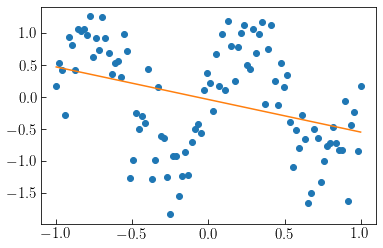

In [17]:
def pcorr(x, y):
    xt = x - x.mean()
    yt = y - y.mean()
    denom = np.linalg.norm(xt) * np.linalg.norm(yt)
    numer = xt @ yt
    return numer / denom

def lsq_slope(x, y):
    p = pcorr(x, y)
    return p * y.std() / x.std(), p

def lsq_int(x, y, m):
    return y.mean() - m * x.mean()

m, p = lsq_slope(x, nonlin)
b = lsq_int(x, nonlin, m)
print(f"Slope: {m:.2}, Correlation: {p:.2f}")
plt.plot(x, nonlin, 'o')
plt.plot(x, x*m + b)

## 2. Least Squares fit

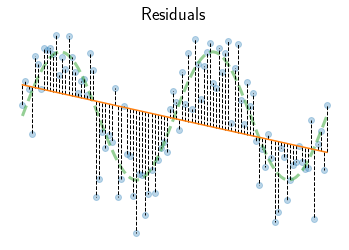

In [18]:
fig, ax = plot_sine(title="Residuals")
line, xd, yd = gen_line(mse_argmin)
for i in range(x.shape[0]):
    ax.plot([x[i], x[i]], [line[i], nonlin[i]], 'k--', lw=1)
ax.plot(x, line)
fig.savefig("../img/fitting/residuals.png")

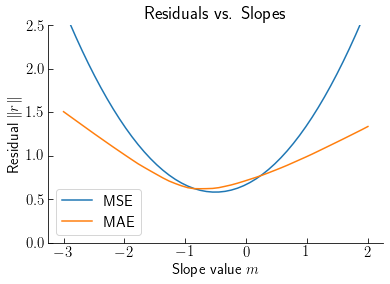

In [19]:
b = 0
m = np.linspace(-3, 2)
res_l2 = []
res_l1 = []
for slope in m:
    y_pred = x * slope
    r_m = np.square(nonlin - y_pred).mean()
    # r_m = rms(r_m) / rms(nonlin)
    res_l2.append(r_m)
    r_m = np.abs(nonlin - y_pred).mean()
    # r_m = rms(nonlin - y_pred) / rms(nonlin)
    res_l1.append(r_m)
plt.plot(m, res_l2, label="MSE")
plt.plot(m, res_l1, label="MAE")
plt.ylabel(r"Residual $\|r\|$")
plt.xlabel("Slope value $m$")
plt.ylim(0, 2.5)
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['top'].set_visible(False)
plt.title("Residuals vs. Slopes")
plt.legend()
plt.savefig("../img/fitting/residual_fit.png")

## Piecewise Fits

In [12]:
class PiecewiseModel:

    def __init__(self, x, data, k, y_actual, type='linear', plot=False):
        self.type = type
        self.regions = np.linspace(x.min(), x.max(), k+2)
        self.knots = [np.abs(x - xi).argmin() for xi in self.regions[1:-1]]
        self.k = k
        
        if type == 'linear':
            self.basis = self.piecewise_linear(x, k)
        elif type == 'cubic':
            self.basis = self.cubic_spline(x, k)
        else:
            raise Exception(f"type {type} not implemented")

        self.fit_predict(data)
        if plot:
            self.plot(x, data, y_actual)


    def fit_predict(self, data):
        """Least squares regression fit"""
        xstar, _, _, _ = np.linalg.lstsq(self.basis, data, rcond=None)
        self.xstar = xstar
        self.y_pred = self.basis @ self.xstar


    def piecewise_linear(self, x, k):
        basis = np.zeros((x.shape[0], k+2))
        basis[:,0] = 1
        basis[:,1] = x

        for i in range(1, k+1):
            activation = x - self.regions[i]
            basis[:, i+1] = np.where(activation > 0, activation, 0)
        return basis
    
    
    def cubic_spline(self, x, k):
        M = 4  # cubic polynomial order
        basis = np.zeros((x.shape[0], k + M))
        for i in range(M):
            basis[:,i] = np.power(x, i)
        for i in range(k):
            coef = x - self.regions[i+1]
            basis[:, M+i] = np.power(np.where(coef > 0, coef, 0), M-1)
        
        return basis


    def loss(self, y_actual, type='mse'):
        if type == 'mse':
            return ((y_actual - self.y_pred)**2).mean()
        elif type == 'mae':
            return ((y_actual - self.y_pred)**2).mean()
        else:
            raise Exception(f"Loss type {type} not implemented")


    def plot(self, x, data, y_actual):
        fig, ax = plt.subplots()
        ax.plot(x, data, '.', alpha=0.5)
        ax.plot(x, self.y_pred, lw=3)
        ax.plot(x[self.knots], self.y_pred[self.knots], 'ko')
        ax.plot(x, y_actual, '--', alpha=1, )
        if self.type == 'linear':
            pre = "Piecewise linear "
        elif self.type == 'cubic':
            pre = "Cubic spline "
        ax.set_title(pre + f"fit k={self.k} knots")
        ax.axis('off')

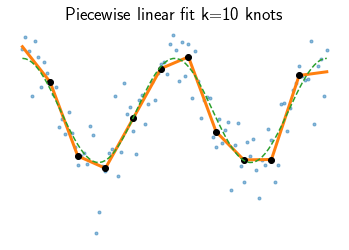

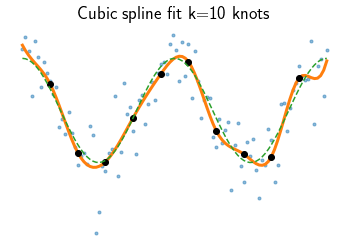

In [13]:
k = 10
linear = PiecewiseModel(x, nonlin, k, sine, plot=True)
spline = PiecewiseModel(x, nonlin, k, sine, "cubic", plot=True)

In [14]:
mse_pw = []
mse_spline = []
folds = np.arange(1, N//3 + 1)
for k in folds:
    linear = PiecewiseModel(x, nonlin, k, sine)
    spline = PiecewiseModel(x, nonlin, k, sine, "cubic")
    mse = linear.loss(sine)
    mse_pw.append(mse)
    mse = spline.loss(sine)
    mse_spline.append(mse)

mse_pw = np.array(mse_pw)
mse_spline = np.array(mse_spline)

Piecewise k*=3
Cubic Spline k*=3


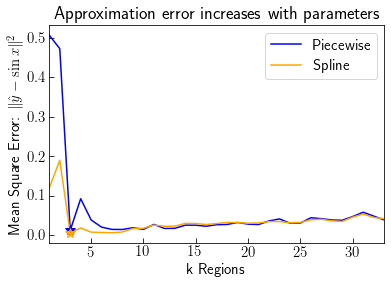

In [15]:
k_pw = mse_pw.argmin()
k_spline = mse_spline.argmin()
print(f"Piecewise k*={k_pw+1}\nCubic Spline k*={k_spline+1}")

plt.plot(folds, mse_pw, label="Piecewise", color='blue')
plt.plot(folds, mse_spline, label="Spline", color='orange')

plt.plot(k_pw+1, mse_pw[k_pw], '*', markersize=10, color='blue')
plt.plot(k_spline+1, mse_spline[k_spline], '*', markersize=10, color='orange')

# plt.scale('log')
plt.legend()
plt.xlim(1, folds.max())
plt.xlabel('k Regions')
plt.ylabel(r'Mean Square Error: $\| \hat y - \sin x \|^2$')
plt.title("Approximation error increases with parameters");

In [16]:
mse_spline

array([0.1192118 , 0.18929325, 0.00525962, 0.0177326 , 0.0071141 ,
       0.00620325, 0.00559457, 0.00754017, 0.01632496, 0.01686735,
       0.0250175 , 0.02197939, 0.02222192, 0.02923143, 0.02887959,
       0.02645264, 0.02892328, 0.03173826, 0.03132962, 0.02957658,
       0.0303547 , 0.03391964, 0.0341232 , 0.03073414, 0.03183983,
       0.03830147, 0.03984916, 0.0356484 , 0.03423372, 0.04521894,
       0.05295974, 0.04443397, 0.04119559])

## Nonlinear Basis

In [83]:
import imageio
import os
import re

def atoi(text):
    return int(text) if text.isdigit() else text

def natural_keys(text):
    '''
    alist.sort(key=natural_keys) sorts in human order
    http://nedbatchelder.com/blog/200712/human_sorting.html
    (See Toothy's implementation in the comments)
    '''
    return [ atoi(c) for c in re.split(r'(\d+)', text) ]

def write_gif(dir, fps=15):
    """Given a directory of images, write a gif with the same name.
    Example: dir = '../img/fitting/poly_fit', output file='../img/fitting/poly_fit.gif'"""
    output = dir + ".gif"
    filenames = os.listdir(dir)
    filenames.sort(key=natural_keys)
    with imageio.get_writer(output, mode='I', fps=fps) as writer:
        for fn in filenames:
            image = imageio.imread(os.path.join(dir, fn))
            writer.append_data(image)

In [101]:
def rmse(y, y_pred):
    return np.sqrt(np.square(y_pred - y).mean())

In [90]:
def poly_basis(x, p):
    A = np.zeros((x.shape[0], p))
    for k in range(p):
        A[:,k] = np.power(x, k)
    return A

max_degree = 30

dir = "../img/fitting/poly_fit"
if os.path.exists(dir):
    filenames = os.listdir(dir)
    [os.remove(os.path.join(dir, fn)) for fn in filenames]

degrees = range(max_degree+1)
train_mse_arr = []
test_mse_arr = []
for p in degrees:
    fig, ax = plot_sine(title=f"Polynomial fit degree {p}")
    A = poly_basis(x, p)
    theta, _, _, _ = lstsq(A, nonlin, rcond=None)
    y_pred = A @ theta
    train_mse_arr.append(rmse(y_pred, nonlin))
    test_mse_arr.append(rmse(y_pred, sine))
    poly_line = ax.plot(x, y_pred)
    fig.savefig(f"../img/fitting/poly_fit/degree{p}.png", dpi=200)
    plt.close(fig=fig)

write_gif(dir)

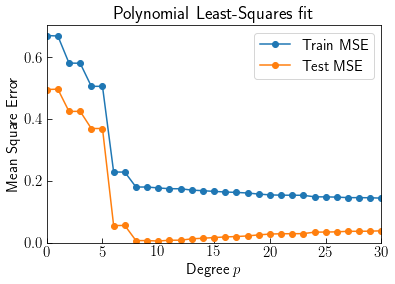

In [334]:
plt.plot(degrees, train_mse_arr, '-o', label="Train MSE")
plt.plot(degrees, test_mse_arr, '-o', label="Test MSE")
plt.legend()
plt.xlim(0, max_degree)
plt.ylim(bottom=0)
plt.title("Polynomial Least-Squares fit")
plt.xlabel(r"Degree $p$")
plt.ylabel("Mean Square Error")
plt.savefig("../img/fitting/poly_fit_mse.png")

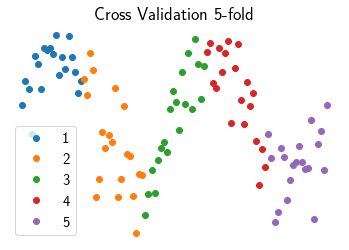

In [143]:
kf = KFold(shuffle=False)
crossval_mse = []
for p in range(max_degree+1):
    val_mse = []
    for train, test in kf.split(x):
        y_train = nonlin[train]
        x_train = x[train]
        x_test = x[test]
        y_test = nonlin[test]

        A = poly_basis(x_train, p)
        theta, _, _, _ = lstsq(A, y_train, rcond=None)
        A_test = poly_basis(x_test, p)
        y_pred = A_test @ theta
        val_mse.append(rmse(y_test, y_pred))
    crossval_mse.append(val_mse)

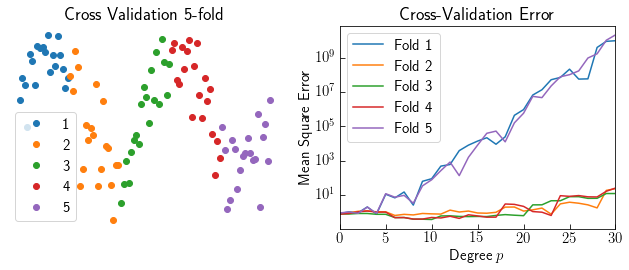

In [337]:
fig, axs = plt.subplots(1,2, tight_layout=True, figsize=(9,4))

kf = KFold(shuffle=False)
fold = 0
for train, test in kf.split(x):
    fold += 1
    y_train = nonlin[train]
    x_train = x[train]
    x_test = x[test]
    y_test = nonlin[test]
    axs[0].plot(x_test, y_test, 'o', label=fold)
axs[0].axis('off')
axs[0].legend()
axs[0].set_title("Cross Validation 5-fold")

degrees = range(max_degree+1)
cv_mse = np.array(crossval_mse)
for fold in range(cv_mse.shape[1]):
    plt.plot(degrees, cv_mse[:, fold], label="Fold "+str(fold+1))
axs[1].set_yscale('log')
axs[1].set_xlim(0, max_degree)
axs[1].legend()
axs[1].set_xlabel(r"Degree $p$")
axs[1].set_ylabel("Mean Square Error")
axs[1].set_title("Cross-Validation Error")

fig.savefig("../img/fitting/cross_validation.png")
# plt.savefig("../img/fitting/crossvalidation_mse.png")

### Regularization

In [272]:
def sinusoid_basis(x, K, freq=None):
    # define base frequency as division of Nyquist
    if freq is None:
        freq = np.pi / 4
    # print("Omega 1", freq)
    A = np.zeros([x.shape[0], 2*K])
    for i, t in enumerate(x):
        for k in range(1, K):
            A[i, 2*k] = np.cos(k * freq * t)
            A[i, 2*k+1] = np.sin(k * freq * t)
    return A

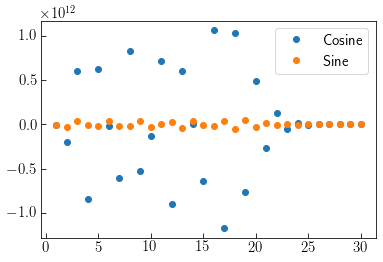

In [170]:
K = 30
freq = np.pi/2

A = sinusoid_basis(x, K, freq)
alp_beta, resid, _, _ = np.linalg.lstsq(A, nonlin, rcond = None)
plt.plot(range(1, K+1), alp_beta[::2], 'o', label="Cosine")
plt.plot(range(1, K+1), alp_beta[1::2], 'o', label="Sine")
plt.legend()

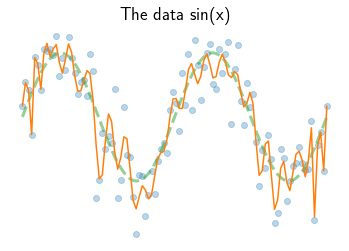

In [166]:
y_pred = A @ alp_beta
plot_sine()
plt.plot(x, y_pred)

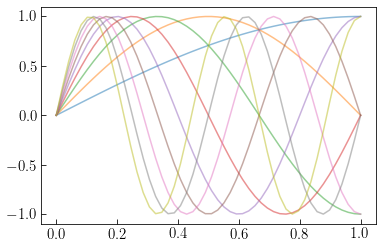

In [305]:
xl = np.linspace(0, 1)
for k in range(1,10):
    plt.plot(xl, np.sin(k * freq * xl), alpha=0.5)

In [205]:
lams = np.logspace(-3, 2, 50)

train_mse = []
test_mse = []
x_mag = []

y_ob = np.concatenate((nonlin, np.zeros(2*K)))
y_act = np.concatenate((sine, np.zeros(2*K)))
for lam in lams:
    A_reg = np.concatenate((A, np.sqrt(lam) * np.eye(2*K)))
    alp_beta, resid, _, _ = np.linalg.lstsq(A_reg, y_ob, rcond = None)
    
    y_pred = A_reg[:N] @ alp_beta
    train_mse.append(rmse(y_pred, y_ob[:N]))
    x_mag.append(np.linalg.norm(alp_beta))
    test_mse.append(rmse(y_pred, y_act[:N]))

    # print(res)

train_mse = np.array(train_mse)
test_mse = np.array(test_mse)

In [273]:
def knee(x, y):
    p = np.array([x, y]).T
    orig = p[0]
    l = p[0] - p[-1]
    l = l / np.linalg.norm(l)
    p = p - orig
    d = p - (p @ l)[:,np.newaxis]*l
    d_mag = np.linalg.norm(d, axis=1)
    d_opt = d_mag.argmax()
    return d_opt

Lambda* = 7.543120063354623


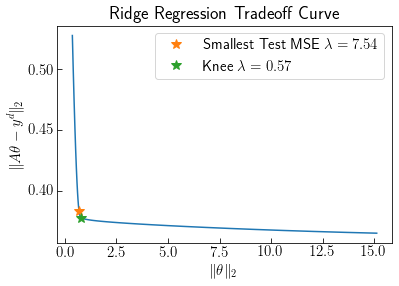

In [339]:
opt = test_mse.argmin()
d_opt = knee(x_mag, train_mse)
lam = lams[opt]
d_lam = lams[d_opt]

A_reg = np.concatenate((A, np.sqrt(lam) * np.eye(2*K)))

alp_beta, resid, _, _ = np.linalg.lstsq(A_reg, y_ob, rcond = None)

print("Lambda* =", lam)

plt.plot(x_mag, train_mse, '-')
plt.plot(x_mag[opt], train_mse[opt], '*', markersize=10, 
        label=rf"Smallest Test MSE $\lambda={lam:.2f}$")
plt.plot(x_mag[d_opt], train_mse[d_opt], '*', markersize=10, 
        label=rf"Knee $\lambda={d_lam:.2f}$")

plt.xlabel(r"$\|\theta\|_2$")
plt.ylabel(r"$\| A \theta - y^d \|_2$")
plt.title("Ridge Regression Tradeoff Curve")
plt.legend()
# plt.ylim(bottom=0)
# plt.plot(x_mag, test_mse, 'o')
plt.savefig("../img/fitting/sine_reg_fit_opt_tradeoff.png")

Lambda* = 0.5689866029018299


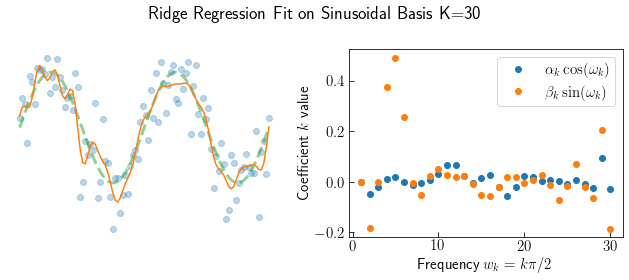

In [312]:
p = K
y_pred = A_reg[:N, :2*p] @ alp_beta[:2*p]
fig, axs = plt.subplots(1,2, tight_layout=True, figsize=(9,4))

plot_sine(title=None, ax=axs[0])
axs[0].plot(x, y_pred)

axs[1].plot(range(1, K+1), alp_beta[::2], 'o', label=r"$\alpha_k \cos(\omega_k)$")
axs[1].plot(range(1, K+1), alp_beta[1::2], 'o', label=r"$\beta_k \sin(\omega_k)$")
axs[1].legend()
axs[1].set_ylabel(r"Coefficient $k$ value")
axs[1].set_xlabel(r"Frequency $w_k = k \pi/2$")

fig.suptitle("Ridge Regression Fit on Sinusoidal Basis K=30")

fig.savefig("../img/fitting/sine_regfit.png")

In [186]:
from sklearn import linear_model

In [332]:
reg = linear_model.LassoCV(alphas=lams)
A = sinusoid_basis(x, K, freq)
reg.fit(A, nonlin)
print("Lambda* =", reg.alpha_)

Lambda* = 0.04291934260128778


/home/alw/.local/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:528: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.01026596974613092, tolerance: 0.00551469151507906
  tol, rng, random, positive)


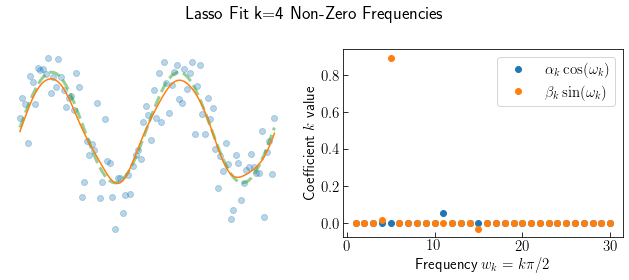

In [333]:
y_pred = reg.predict(A)
fig, axs = plt.subplots(1,2, tight_layout=True, figsize=(9,4))

plot_sine(title=None, ax=axs[0])
axs[0].plot(x, y_pred)

axs[1].plot(range(1, K+1), reg.coef_[::2], 'o', label=r"$\alpha_k \cos(\omega_k)$")
axs[1].plot(range(1, K+1), reg.coef_[1::2], 'o', label=r"$\beta_k \sin(\omega_k)$")
axs[1].legend()
axs[1].set_ylabel(r"Coefficient $k$ value")
axs[1].set_xlabel(r"Frequency $w_k = k \pi/2$")

fig.suptitle("Lasso Fit k=4 Non-Zero Frequencies")

fig.savefig("../img/fitting/sine_lasso.png")

In [329]:
from math import factorial

In [331]:
total = 0
for k in range(1, K):
    combs = factorial(K) / (factorial(k) * factorial(K-k))
    total += combs
print(f"{total:,}")

1,073,741,822.0


In [309]:
np.nonzero(reg.coef_)

(array([ 7,  9, 20, 29]),)

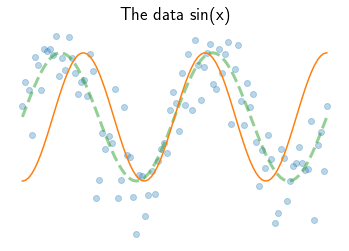

In [326]:
y = np.sin(freq * 5 * x)
plot_sine()
plt.plot(x, y)

### Nonlinear Least Squares

In [21]:
from scipy.optimize import curve_fit

6.283185307179586
[5.24664900e-09 9.84043438e+00 9.90985970e+00]


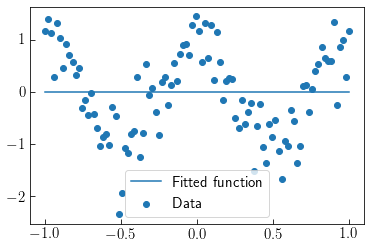

In [23]:
# x_data = np.linspace(-5, 5, num=50)
# y_data = 2.9 * np.sin(1.5 * x_data) + np.random.normal(size=50)
x_data = x
y_data = nonlin

def test_func(x, a, b, phi):
    return a*np.sin(b * x + phi)

params, params_covariance = curve_fit(test_func, x_data, y_data,
                                               p0=[1, 9.2205196, 10])

print(coef)
print(params)
plt.figure(figsize=(6, 4))
plt.scatter(x_data, y_data, label='Data')
plt.plot(x_data, test_func(x_data, *params),
         label='Fitted function')

plt.legend(loc='best')

plt.show()

## Classification

In [25]:
from tensorflow import keras

2022-05-21 08:19:40.362330: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/alw/roomba_ws/devel/lib:/home/alw/ara_navigation/devel/lib:/home/alw/autonomous_mobile_manipulation_ws/devel/lib:/opt/ros/melodic/lib
2022-05-21 08:19:40.362423: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [26]:
(x_train, y_train), (x_test, y_test) = keras.datasets.mnist.load_data()

In [27]:
def display_5_imgs(nrows, images, im_shape, digits=True):
    """plot images in a nrow by 5 array.

    Args:
        nrows ([type]): [description]
        images (ndarray): expects image shape for be formatted square. 
    """
    _, axes = plt.subplots(nrows=nrows, ncols=5, figsize=(10, 10))
    for idx, image in zip(range(5 * nrows), images):
        if nrows == 1:
            ax = axes[idx]
        else:
            ax = axes[idx // 5, idx % 5]
        ax.set_axis_off()
        if digits:
            ax.imshow(image.reshape(im_shape), cmap=plt.cm.gray_r, interpolation='nearest')
        else: 
            ax.imshow(image.reshape(im_shape), interpolation='nearest')

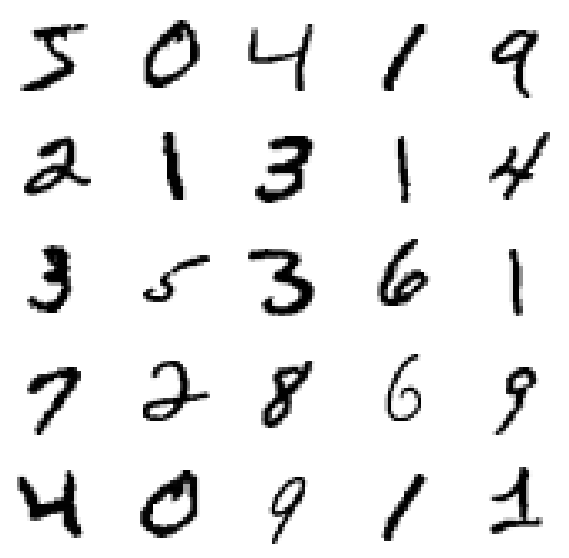

In [28]:
display_5_imgs(5, x_train, (28, 28))

In [29]:
from sklearn.decomposition import PCA

In [30]:
x_reshaped = x_train.reshape(-1, x_train.shape[1]*x_train.shape[2])

In [31]:
pca = PCA(n_components=2)
pca_digits = pca.fit_transform(x_reshaped)

In [32]:
print(f"PCA 2 components explain {pca.explained_variance_ratio_.sum():.0%} of variance.")

PCA 2 components explain 17% of variance.


In [33]:
rng = np.random.default_rng()
N = 5000
index = rng.choice(x_train.shape[0], 5000, replace=False)

In [34]:
y_sample = y_train[index]
x_sample = pca_digits[index]
labels, counts = np.unique(y_sample, return_counts=True)
print(counts.mean(), counts.var())
priors = [x/N for x in counts]
print(priors)

500.0 763.2
[0.0904, 0.1086, 0.0974, 0.095, 0.0982, 0.099, 0.101, 0.1026, 0.0982, 0.1096]


In [35]:
centroids = []
covariance = []
for d in labels:
    x_digit = x_sample[y_sample == d]
    centroids.append(x_digit.mean(axis=0))
    covariance.append(np.cov(x_digit.T))
centoids = np.array(centroids)
covariance = np.array(covariance)

(-1199.2507501422378,
 2282.0110431585354,
 -1388.4886511883387,
 1423.5334208445752)

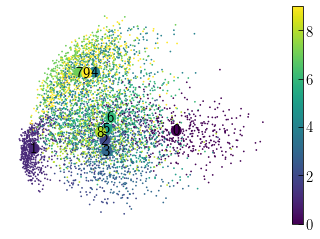

In [36]:
plt.scatter(pca_digits[index,0], pca_digits[index,1], 
        s=.5, c=y_train[index], cmap='viridis')
plt.scatter(centoids[:,0], centoids[:,1], s=100, c=labels, cmap='viridis')
for i, d in enumerate(labels):
        plt.text(centoids[i,0], centoids[i,1], d, c='k',
        horizontalalignment='center', verticalalignment='center',)
plt.colorbar()
plt.axis('off')

In [37]:
from matplotlib import cm

In [38]:
label_c = cm.viridis(labels)

In [39]:
clusters = {
    0: 0,
    1: 1,
    2: 2,
    3: 2,
    4: 3,
    5: 2,
    6: 2,
    7: 3,
    8: 2,
    9: 3
}

y_sample_cluster = [clusters[y] for y in y_sample]
x_test_sq = x_test.reshape(-1, 28*28)
y_test_cluster = [clusters[y] for y in y_test]

In [40]:
lda = LinearDiscriminantAnalysis()
lda.fit(x_sample, y_sample_cluster)
lda.score(pca.transform(x_test_sq), y_test_cluster)

0.8532

/home/alw/.local/lib/python3.7/site-packages/ipykernel_launcher.py:27: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.


(-1199.2507501422378,
 2282.0110431585354,
 -1388.4886511883387,
 1423.5334208445752)

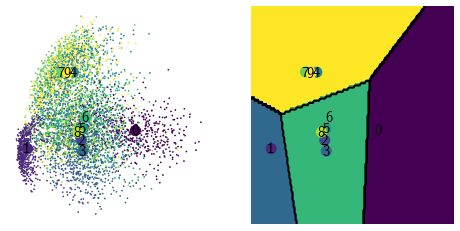

In [41]:
fig, axs = plt.subplots(1, 2, figsize=(8, 4))

axs[0].scatter(pca_digits[index,0], pca_digits[index,1], 
        s=.5, c=y_train[index], cmap='viridis')
axs[0].scatter(centoids[:,0], centoids[:,1], s=100, c=labels, cmap='viridis')
for i, d in enumerate(labels):
        axs[0].text(centoids[i,0], centoids[i,1], d, c='k',
        horizontalalignment='center', verticalalignment='center',)
# plt.colorbar(ax=axs[0])
axs[0].axis('off')
xlim = axs[0].get_xlim()
ylim = axs[0].get_ylim()

axs[1].scatter(centoids[:,0], centoids[:,1], s=100, c=labels, cmap='viridis')
for i, d in enumerate(labels):
        axs[1].text(centoids[i,0], centoids[i,1], d, c='k',
                horizontalalignment='center', verticalalignment='center',)
axs[1].set_xlim(*xlim)
axs[1].set_ylim(*ylim)
nx, ny = 200, 100
x_min, x_max = axs[1].get_xlim()
y_min, y_max = axs[1].get_ylim()
xx, yy = np.meshgrid(np.linspace(x_min, x_max, nx), np.linspace(y_min, y_max, ny))
Z = lda.predict_proba(np.c_[xx.ravel(), yy.ravel()]).argmax(axis=1)
Z = Z.reshape(xx.shape)
axs[1].pcolormesh(
xx, yy, Z, cmap="viridis", zorder=0
)
plt.contour(xx, yy, Z, [0, 1, 2, 3], linewidths=2.0, colors="k")
plt.axis('off')
